Week 10 · Day 4 — Evaluation & Error Analysis
Why this matters

Training accuracy alone is misleading. Proper evaluation (confusion matrix, per-class metrics, ROC/PR curves) shows where the model struggles. Error analysis (looking at misclassified samples) is how you improve models beyond just tuning hyperparams.

Theory Essentials

Confusion matrix: counts TP, FP, TN, FN.

Precision/Recall/F1: better than accuracy for imbalance.

ROC-AUC: tradeoff between TPR/FPR.

PR-AUC: better when positive class is rare.

Threshold tuning: adjusting decision cutoff improves balance.

Error analysis: manually inspect misclassified examples → reveals data/model issues.

Confusion Matrix:
 [[2 3]
 [3 2]]

Classification Report:
               precision    recall  f1-score   support

           0      0.400     0.400     0.400         5
           1      0.400     0.400     0.400         5

    accuracy                          0.400        10
   macro avg      0.400     0.400     0.400        10
weighted avg      0.400     0.400     0.400        10

ROC-AUC: 0.32
PR-AUC: 0.409


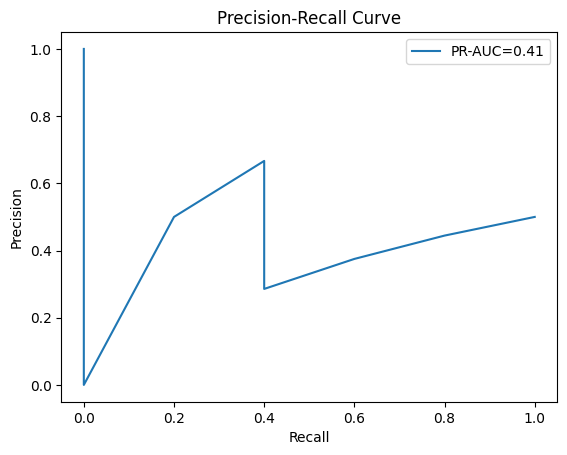

Example 1: true=1, pred=0, prob=0.05
Example 2: true=0, pred=1, prob=0.86
Example 4: true=1, pred=0, prob=0.26
Example 5: true=0, pred=1, prob=0.68
Example 6: true=0, pred=1, prob=0.57
Example 9: true=1, pred=0, prob=0.19


In [2]:
# Setup
import numpy as np, torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt

torch.manual_seed(42)

# Fake predictions (logits) and labels
y_true = np.array([0, 1, 0, 1, 1, 0, 0, 1, 0, 1])
logits = torch.randn(len(y_true), 2)
y_probs = torch.softmax(logits, dim=1)[:,1].detach().numpy()
y_pred = (y_probs >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Per-class metrics
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3))

# ROC-AUC
roc = roc_auc_score(y_true, y_probs)
print("ROC-AUC:", round(roc, 3))

# PR Curve
prec, rec, thr = precision_recall_curve(y_true, y_probs)
pr_auc = auc(rec, prec)
print("PR-AUC:", round(pr_auc, 3))

# Plot PR Curve
plt.plot(rec, prec, label=f"PR-AUC={pr_auc:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve")
plt.legend(); plt.show()

# Misclassified examples
for i, (yt, yp, prob) in enumerate(zip(y_true, y_pred, y_probs)):
    if yt != yp:
        print(f"Example {i}: true={yt}, pred={yp}, prob={prob:.2f}")


🔹 ROC-AUC

ROC (Receiver Operating Characteristic) curve: plots

x-axis: False Positive Rate (FPR = FP / (FP+TN))

y-axis: True Positive Rate (TPR = Recall = TP / (TP+FN))

Each threshold (0.0 → 1.0) gives a different point on the curve.

AUC (Area Under the Curve): measures how well the model separates classes.

1.0 = perfect separation

0.5 = random guessing

<0.5 means the model is worse than random (inverted).

👉 Intuition: ROC-AUC tells you “how good is my model at ranking positives higher than negatives?”

🔹 Precision-Recall (PR) curve

Precision = TP / (TP + FP)
“Of all predicted positives, how many are truly positive?”

Recall = TP / (TP + FN)
“Of all actual positives, how many did I catch?”

The PR curve plots Precision (y-axis) vs Recall (x-axis) across thresholds.

Trade-off:

High recall → you catch almost all positives, but precision might drop (more false alarms).

High precision → fewer false alarms, but you might miss positives (low recall).

👉 Useful when classes are imbalanced (e.g., fraud detection, rare diseases), because ROC can be overly optimistic in imbalanced data.

🔹 PR-AUC

The area under the PR curve.

Higher = better balance between precision & recall.

Especially informative with imbalanced datasets, since it focuses on performance for the positive class.

1) Core (10–15 min)

Task: Run confusion matrix with a new threshold (e.g., 0.3 instead of 0.5). Compare FN vs FP.

In [3]:
y_pred = (y_probs >= 0.3).astype(int)
print(confusion_matrix(y_true, y_pred))


[[0 5]
 [3 2]]


2) Practice (10–15 min)

Task: Generate both ROC and PR curves on the same dataset. Which curve is more informative here?

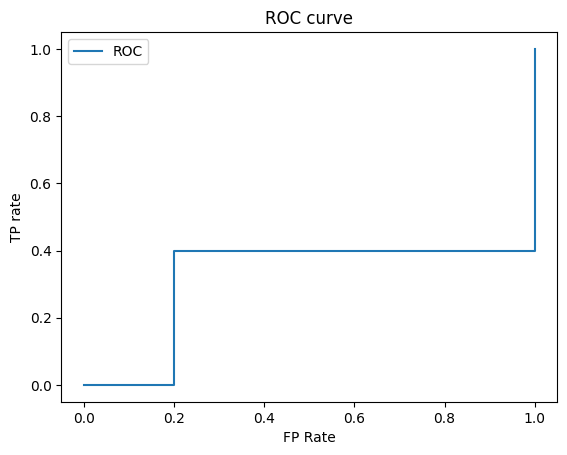

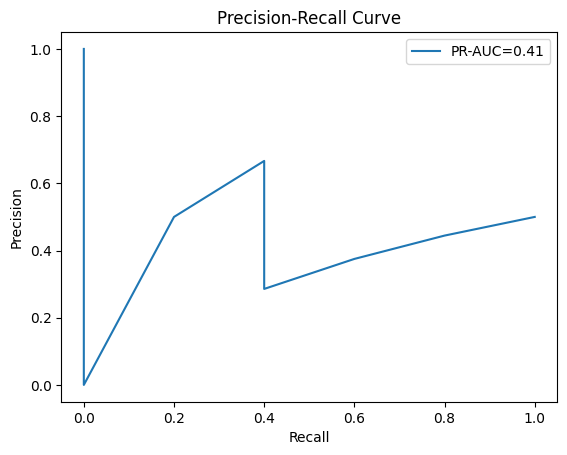

In [7]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.plot(fpr, tpr, label="ROC")
plt.xlabel("FP Rate"); plt.ylabel("TP rate"); plt.title("ROC curve")
plt.legend(); plt.show()



plt.plot(rec, prec, label=f"PR-AUC={pr_auc:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve")
plt.legend(); plt.show()

The PR curve is more informative, because it highlights that although ROC might look “OK-ish,” the model actually performs poorly at precision/recall trade-offs (harder to catch positives reliably).

3) Stretch (optional, 10–15 min)

Task: Collect the 3 most confident misclassifications (highest wrong probs). Print them.

In [9]:
# --- Top-3 most confident misclassifications ---
# Get full class probabilities (works for binary or multi-class)
probs = torch.softmax(logits, dim=1).detach().numpy()        # shape: [N, C]
y_pred = probs.argmax(axis=1)                                 # predicted class per sample

idx_mis = np.where(y_true != y_pred)[0]                       # indices of misclassifications
if len(idx_mis) == 0:
    print("No misclassifications.")
else:
    # Confidence of the WRONG prediction = prob of the predicted (incorrect) class
    wrong_conf = probs[idx_mis, y_pred[idx_mis]]              # shape: [#mis]
    # Sort misclassified by descending confidence and take top-3
    topk = idx_mis[np.argsort(-wrong_conf)][:3]

    print("\nTop-3 most confident misclassifications:")
    for i in topk:
        pred_class = y_pred[i]
        true_class = y_true[i]
        pred_prob  = probs[i, pred_class]
        true_prob  = probs[i, true_class]
        print(f"idx={i:2d}  true={true_class}  pred={pred_class}  "
              f"pred_prob={pred_prob:.3f}  true_prob={true_prob:.3f}")



Top-3 most confident misclassifications:
idx= 1  true=1  pred=0  pred_prob=0.953  true_prob=0.047
idx= 2  true=0  pred=1  pred_prob=0.863  true_prob=0.137
idx= 9  true=1  pred=0  pred_prob=0.806  true_prob=0.194


Mini-Challenge (≤40 min)

Task: On a small IMDB subset (e.g., 500 reviews):

Train a BiLSTM sentiment model.

Compute confusion matrix, ROC-AUC, PR-AUC.

Print 5 misclassified reviews (with true label, predicted label, probability).

Acceptance Criteria:

Outputs confusion matrix and ROC/PR AUC values.

Lists 5 misclassified reviews with probabilities.

Short written insight: what types of reviews are hardest for the model?

Epoch 1 - Loss 0.6944
Epoch 2 - Loss 0.6493
Epoch 3 - Loss 0.5751

Confusion Matrix:
 [[346 166]
 [275 213]]

Classification Report:
               precision    recall  f1-score   support

           0      0.557     0.676     0.611       512
           1      0.562     0.436     0.491       488

    accuracy                          0.559      1000
   macro avg      0.560     0.556     0.551      1000
weighted avg      0.560     0.559     0.552      1000

ROC-AUC: 0.591
PR-AUC: 0.564


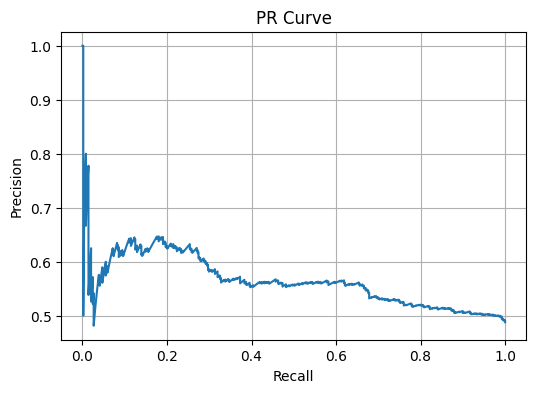


Top-5 confident misclassifications:

true=1 pred=0 P(pos)=0.082
This is a VERY good movie. I give it a 10.<br /><br />It's very different in that it's kind of a long stalking scene all the way through. The fact that the main character is mute is used throughout th…

true=1 pred=0 P(pos)=0.095
I gave this a 10 because it's the best film of its kind...a good old-fashioned T & A film in the shadow and spirit of "Animal House." I saw this with a similar film called "Swap Meet" and both were go…

true=1 pred=0 P(pos)=0.102
Pierre Jolivet plays a Don Quixote character, unable to speak, living in a world incompatible with modern life. He trusts to his homemade weaponry - helmet, sleeves, and spear - made out of hubcaps, s…

true=1 pred=0 P(pos)=0.112
Despite what its critics ensue, I enjoyed immensely for precisely what it is. Eyecandy for both sides of the gender spectrum. Soderberg has done the artsy hard edge stuff before, won Oscars, is at the…

true=1 pred=0 P(pos)=0.138
An intense thri

In [13]:
# Setup

import re, random, numpy as np, torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# ---- 1) Load IMDB from HuggingFace ----
dataset = load_dataset("imdb")

# Sample smaller subsets (for CPU)
N_TRAIN, N_TEST = 1000, 1000
train_subset = dataset["train"].shuffle(seed=SEED).select(range(N_TRAIN))
test_subset  = dataset["test"].shuffle(seed=SEED).select(range(N_TEST))

# ---- 2) Tokenizer & Vocab ----
def simple_tokenize(s: str):
    return re.findall(r"\b\w+\b", s.lower())

counter = Counter()
for row in train_subset:
    counter.update(simple_tokenize(row["text"]))

MAX_VOCAB = 20000
PAD, UNK = "<pad>", "<unk>"
itos = [PAD, UNK] + [w for w, _ in counter.most_common(MAX_VOCAB - 2)]
stoi = {w:i for i,w in enumerate(itos)}

def numericalize(tokens):
    return [stoi.get(tok, stoi[UNK]) for tok in tokens]

MAX_LEN = 200

class IMDBDataset(Dataset):
    def __init__(self, hf_dataset):
        self.texts = hf_dataset["text"]
        self.labels = hf_dataset["label"]
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        return self.labels[i], simple_tokenize(self.texts[i])

def collate(batch):
    ys, toks = zip(*batch)
    ids_list = [numericalize(t)[:MAX_LEN] for t in toks]
    lens = torch.tensor([len(ids) for ids in ids_list], dtype=torch.long)
    maxlen = max(lens.max().item(), 1)
    padded = torch.full((len(ids_list), maxlen), fill_value=stoi[PAD], dtype=torch.long)
    for i, ids in enumerate(ids_list):
        padded[i, :len(ids)] = torch.tensor(ids, dtype=torch.long)
    return padded, lens, torch.tensor(ys, dtype=torch.float32)

train_ds = IMDBDataset(train_subset)
test_ds  = IMDBDataset(test_subset)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate)

# ---- 3) BiLSTM Model ----
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hidden=64, bidirectional=True, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=stoi[PAD])
        self.lstm = nn.LSTM(emb_dim, hidden, batch_first=True, bidirectional=bidirectional)
        out_dim = hidden * (2 if bidirectional else 1)
        self.fc = nn.Linear(out_dim, 1)
        self.drop = nn.Dropout(dropout)
    def forward(self, x, lengths):
        emb = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed)
        if self.lstm.bidirectional:
            h = torch.cat([h_n[-2], h_n[-1]], dim=1)
        else:
            h = h_n[-1]
        return self.fc(self.drop(h)).squeeze(1)

device = torch.device("cpu")
model = BiLSTMClassifier(len(itos)).to(device)

# ---- 4) Train ----
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(3):  # small for speed
    model.train(); total_loss=0
    for x, lengths, y in train_loader:
        x, lengths, y = x.to(device), lengths.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x, lengths)
        loss = criterion(logits, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()*x.size(0)
    print(f"Epoch {epoch+1} - Loss {total_loss/len(train_ds):.4f}")

# ---- 5) Evaluate ----
model.eval()
all_labels, all_probs, all_preds = [], [], []
with torch.no_grad():
    for x, lengths, y in test_loader:
        x, lengths, y = x.to(device), lengths.to(device), y.to(device)
        logits = model(x, lengths)
        probs = torch.sigmoid(logits)
        preds = (probs>=0.5).long()

        all_labels.extend(y.cpu().numpy().astype(int).tolist())
        all_probs.extend(probs.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().astype(int).tolist())

all_labels, all_probs, all_preds = map(np.array, [all_labels, all_probs, all_preds])

print("\nConfusion Matrix:\n", confusion_matrix(all_labels, all_preds))
print("\nClassification Report:\n", classification_report(all_labels, all_preds, digits=3))
print("ROC-AUC:", round(roc_auc_score(all_labels, all_probs), 3))

prec, rec, thr = precision_recall_curve(all_labels, all_probs)
print("PR-AUC:", round(auc(rec, prec), 3))

plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve"); plt.show()

# ---- 6) Misclassified examples (fixed) ----
wrong_idx = np.where(all_labels != all_preds)[0]
wrong_conf = np.array([all_probs[i] if all_preds[i]==1 else 1-all_probs[i] for i in wrong_idx])
top5 = wrong_idx[np.argsort(-wrong_conf)[:5]]

print("\nTop-5 confident misclassifications:")
for i_np in top5:
    i = int(i_np)  # HF needs a Python int
    print(f"\ntrue={all_labels[i]} pred={all_preds[i]} P(pos)={all_probs[i]:.3f}")
    txt = test_subset[i]["text"].replace("\n"," ")
    print(txt[:200] + "…")




Notes / Key Takeaways

Accuracy ≠ full story, especially with class imbalance.

Confusion matrices reveal type of errors.

ROC-AUC good for overall ranking ability; PR-AUC better for imbalance.

Threshold tuning shifts precision vs recall tradeoff.

Error analysis (reading mistakes) often reveals data issues.

Reflection

Why might PR-AUC be more useful than ROC-AUC for rare positive classes?

What can misclassified samples reveal about dataset bias?

Why might PR-AUC be more useful than ROC-AUC for rare positive classes?

ROC-AUC can look deceptively high when positives are rare, because False Positive Rate = FP / (FP+TN). With many TNs, FPR stays small even if the model makes lots of false alarms.

PR-AUC instead focuses directly on precision (how many predicted positives are correct) and recall (how many real positives are caught). This makes it much more sensitive to performance on the minority (positive) class, which is usually the one we care about (e.g., fraud, disease).

What can misclassified samples reveal about dataset bias?

They highlight systematic weaknesses of the model and the data.

If many false negatives are short or sarcastic reviews, it suggests the dataset underrepresents these patterns.

If many false positives are long, mixed reviews (positive + negative words), it shows the dataset may not teach the model to handle nuanced sentiment.

By analyzing misclassifications, we can spot imbalances, missing linguistic styles, cultural phrasing, or noisy labels in the dataset — all forms of bias that limit model generalization.